## Categorising countries

### Data Source

The data used in this task was orginally sourced from Help.NGO. This international non-governmental organisation specialises in emergency response, preparedness, and risk mitigation.  

### Dataset Attributes
- country: name of the country
- child_mort: death of children under 5 years of age per 1000 live births
- exports: exports of goods and services per capita. Given as a percentage of the GDP per capita
- health: total health spending per capita. Given as a percentage of GDP per capita
- imports: imports of goods and services per capita. Given as a percentage of the GDP per capita
- income: net income per person
- inflation: the measurement of the annual growth rate of the Total GDP
- life_expec: the average number of years a new born child would live if the current mortality patterns remain the same
- total_fer: the number of children that would be born to each woman if the current age-fertility rates remains the same
- gdpp: the GDP per capita. Calculated as the Total GDP divided by the total population.

## Objective  
To group countries using socio-economic and health factors to determine the development status of the country.

In [37]:
# Import libraries
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

In [38]:
# Random state seed
rseed = 42

## Load and explore data

In [39]:
# Import the dataset
df =  pd.read_csv('Country-data.csv')
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [40]:
# Check the shape
df.shape

(167, 10)

In [41]:
# Check datatypes & counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [42]:
# Get descriptive statistics
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [43]:
# Identify any missing data
df.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

## Preprocessing and Feature Selection

In [44]:
# Drop any non-numeric features (columns)
df.drop('country', axis = 1, inplace = True)
df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [45]:
df.columns

Index(['child_mort', 'exports', 'health', 'imports', 'income', 'inflation',
       'life_expec', 'total_fer', 'gdpp'],
      dtype='object')

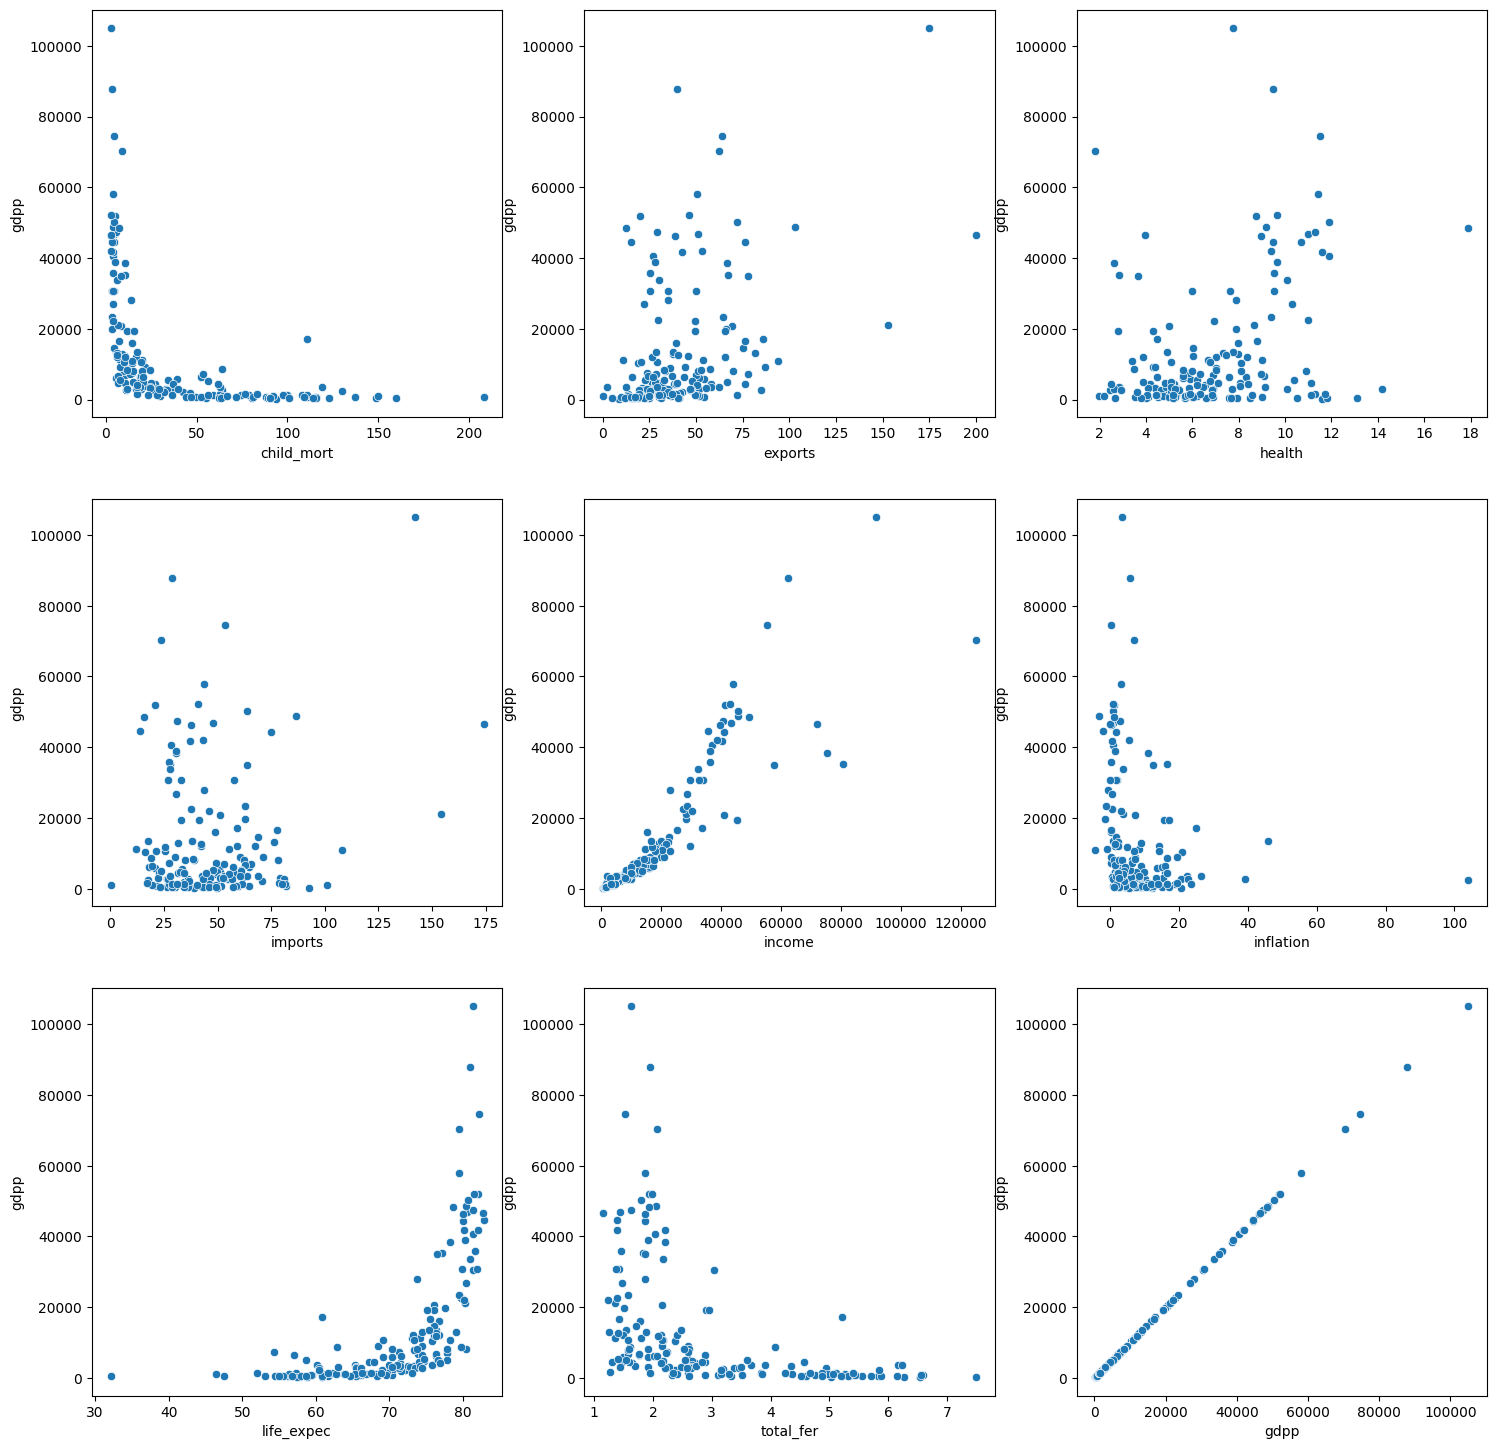

In [46]:
# Create a correlation map of features to explore relationships between features
# Hint: Explore seaborn heatmap

# Correlation maps exploring relationships between gdpp and all the other features
columns = df.columns.tolist()

fig, axes = plt.subplots(3, 3, figsize =(18, 18))

axes = axes.flatten()

for i, var in enumerate(columns):
  sns.scatterplot(ax = axes[i], x = df[var], y = df['gdpp'])

The scatter plots for child_mort vs gdpp, income vs gdpp and inflation vs gdpp has many observations that are close to each other indicating they would be good for seperating into clusters. The income vs gdpp scatter plot would probably be the best overall as it has better correlation than the others.

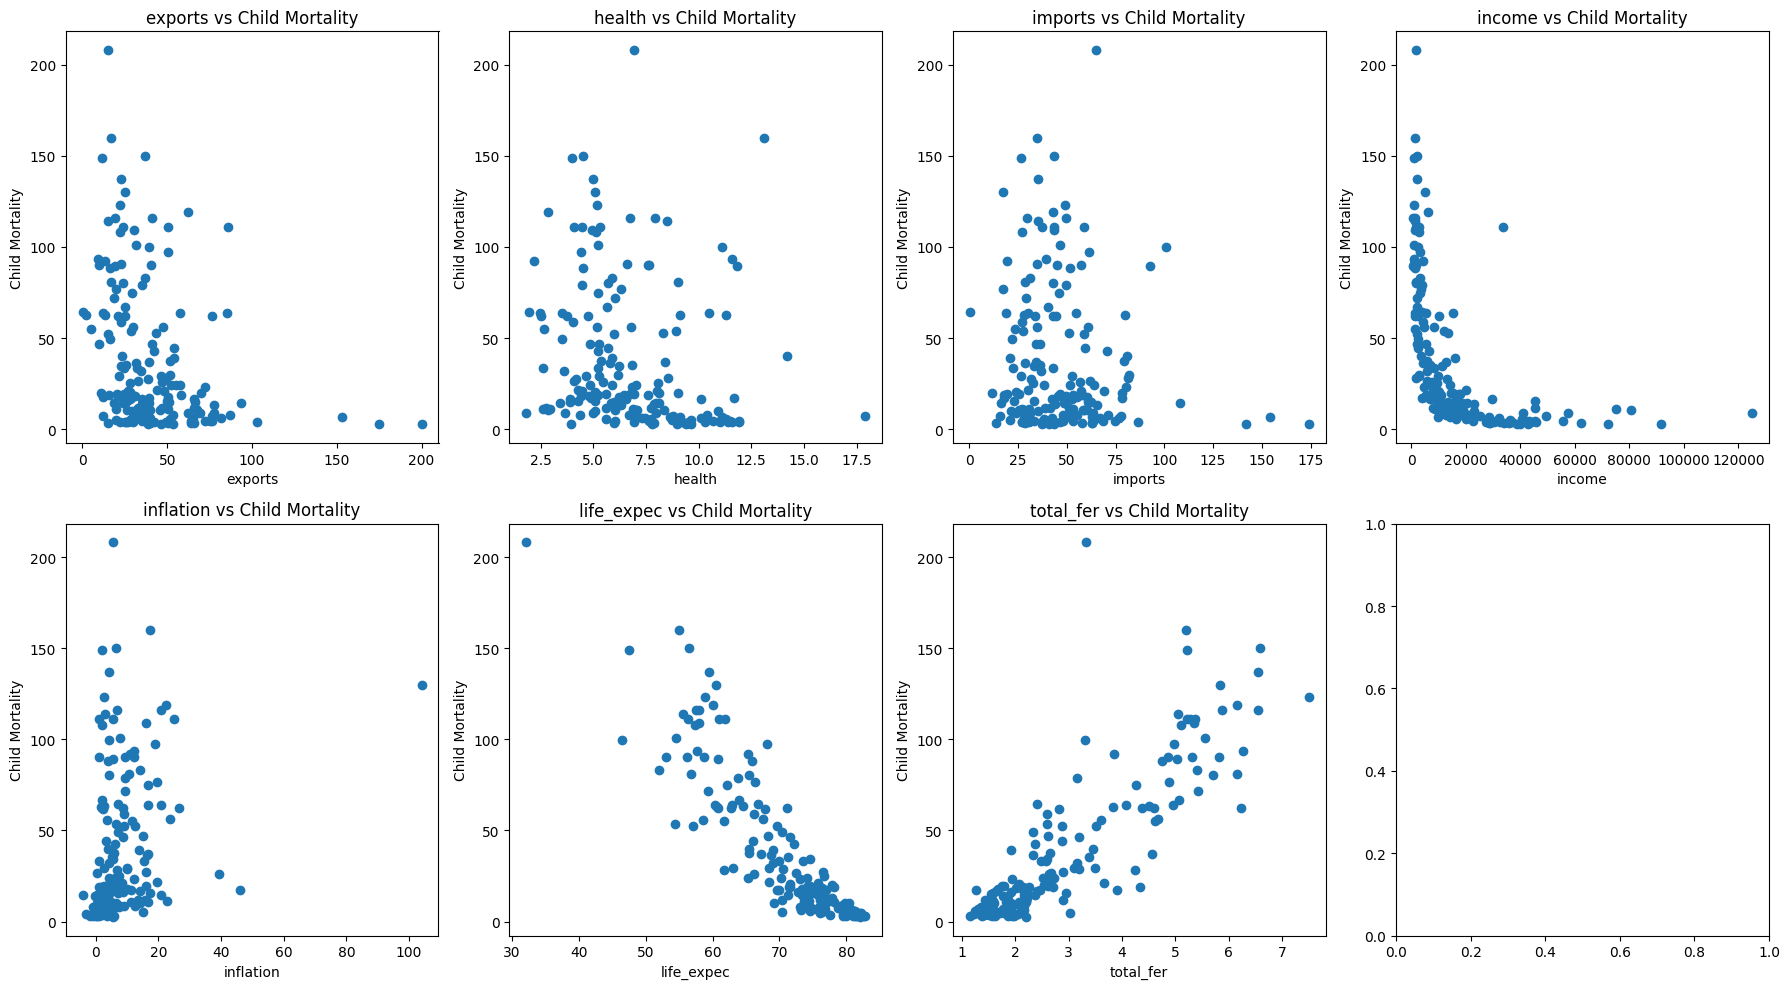

In [47]:
# Explore the continuous independent features against child_mort using scatter plots.
# Define the independent variables
independent_vars = [col for col in df.columns if col != 'child_mort' and col != 'gdpp']

# Create subplots for each independent variable against child_mort
fig, axes = plt.subplots(2, 4, figsize=(18, 10))

for ax, var in zip(axes.flatten(), independent_vars):
    ax.scatter(df[var], df['child_mort'])
    ax.set_xlabel(var)
    ax.set_ylabel('Child Mortality')
    ax.set_title(f'{var} vs Child Mortality')

plt.tight_layout()
plt.show()

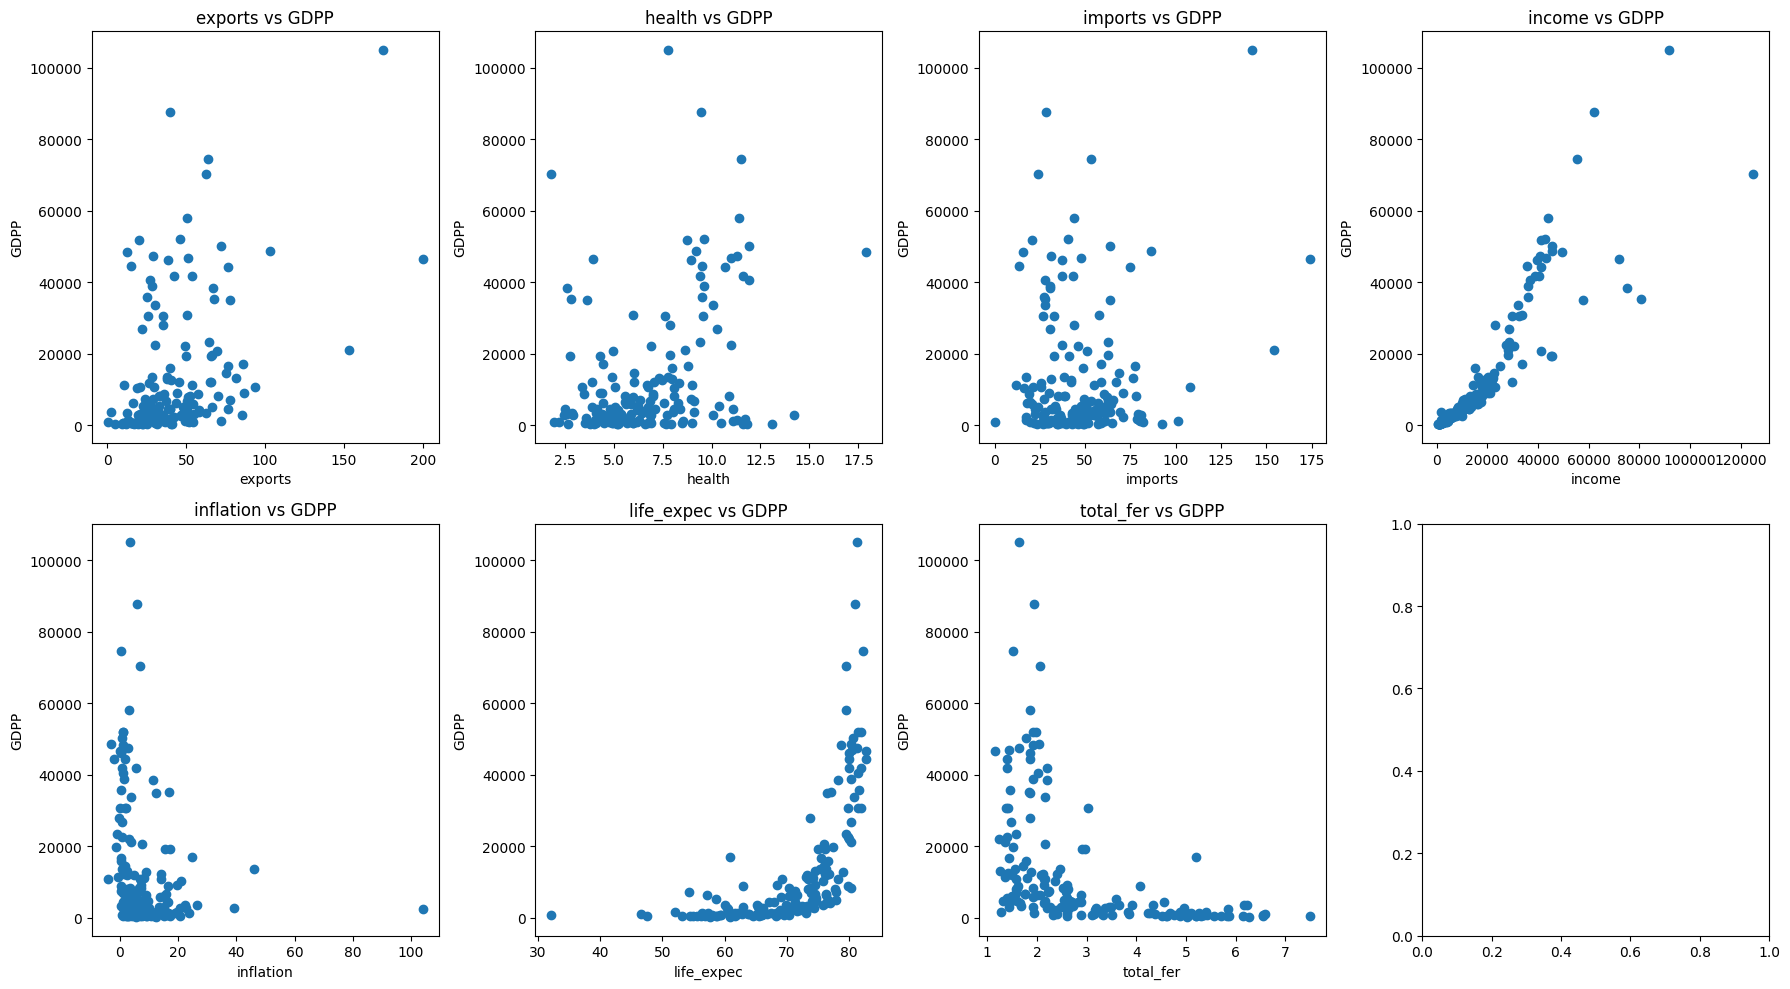

In [48]:
# Explore the continuous independent features against gdpp using scatter plots.
fig, axes = plt.subplots(2, 4, figsize=(18, 10))

for ax, var in zip(axes.flatten(), independent_vars):
    ax.scatter(df[var], df['gdpp'])
    ax.set_xlabel(var)
    ax.set_ylabel('GDPP')
    ax.set_title(f'{var} vs GDPP')

plt.tight_layout()
plt.show()


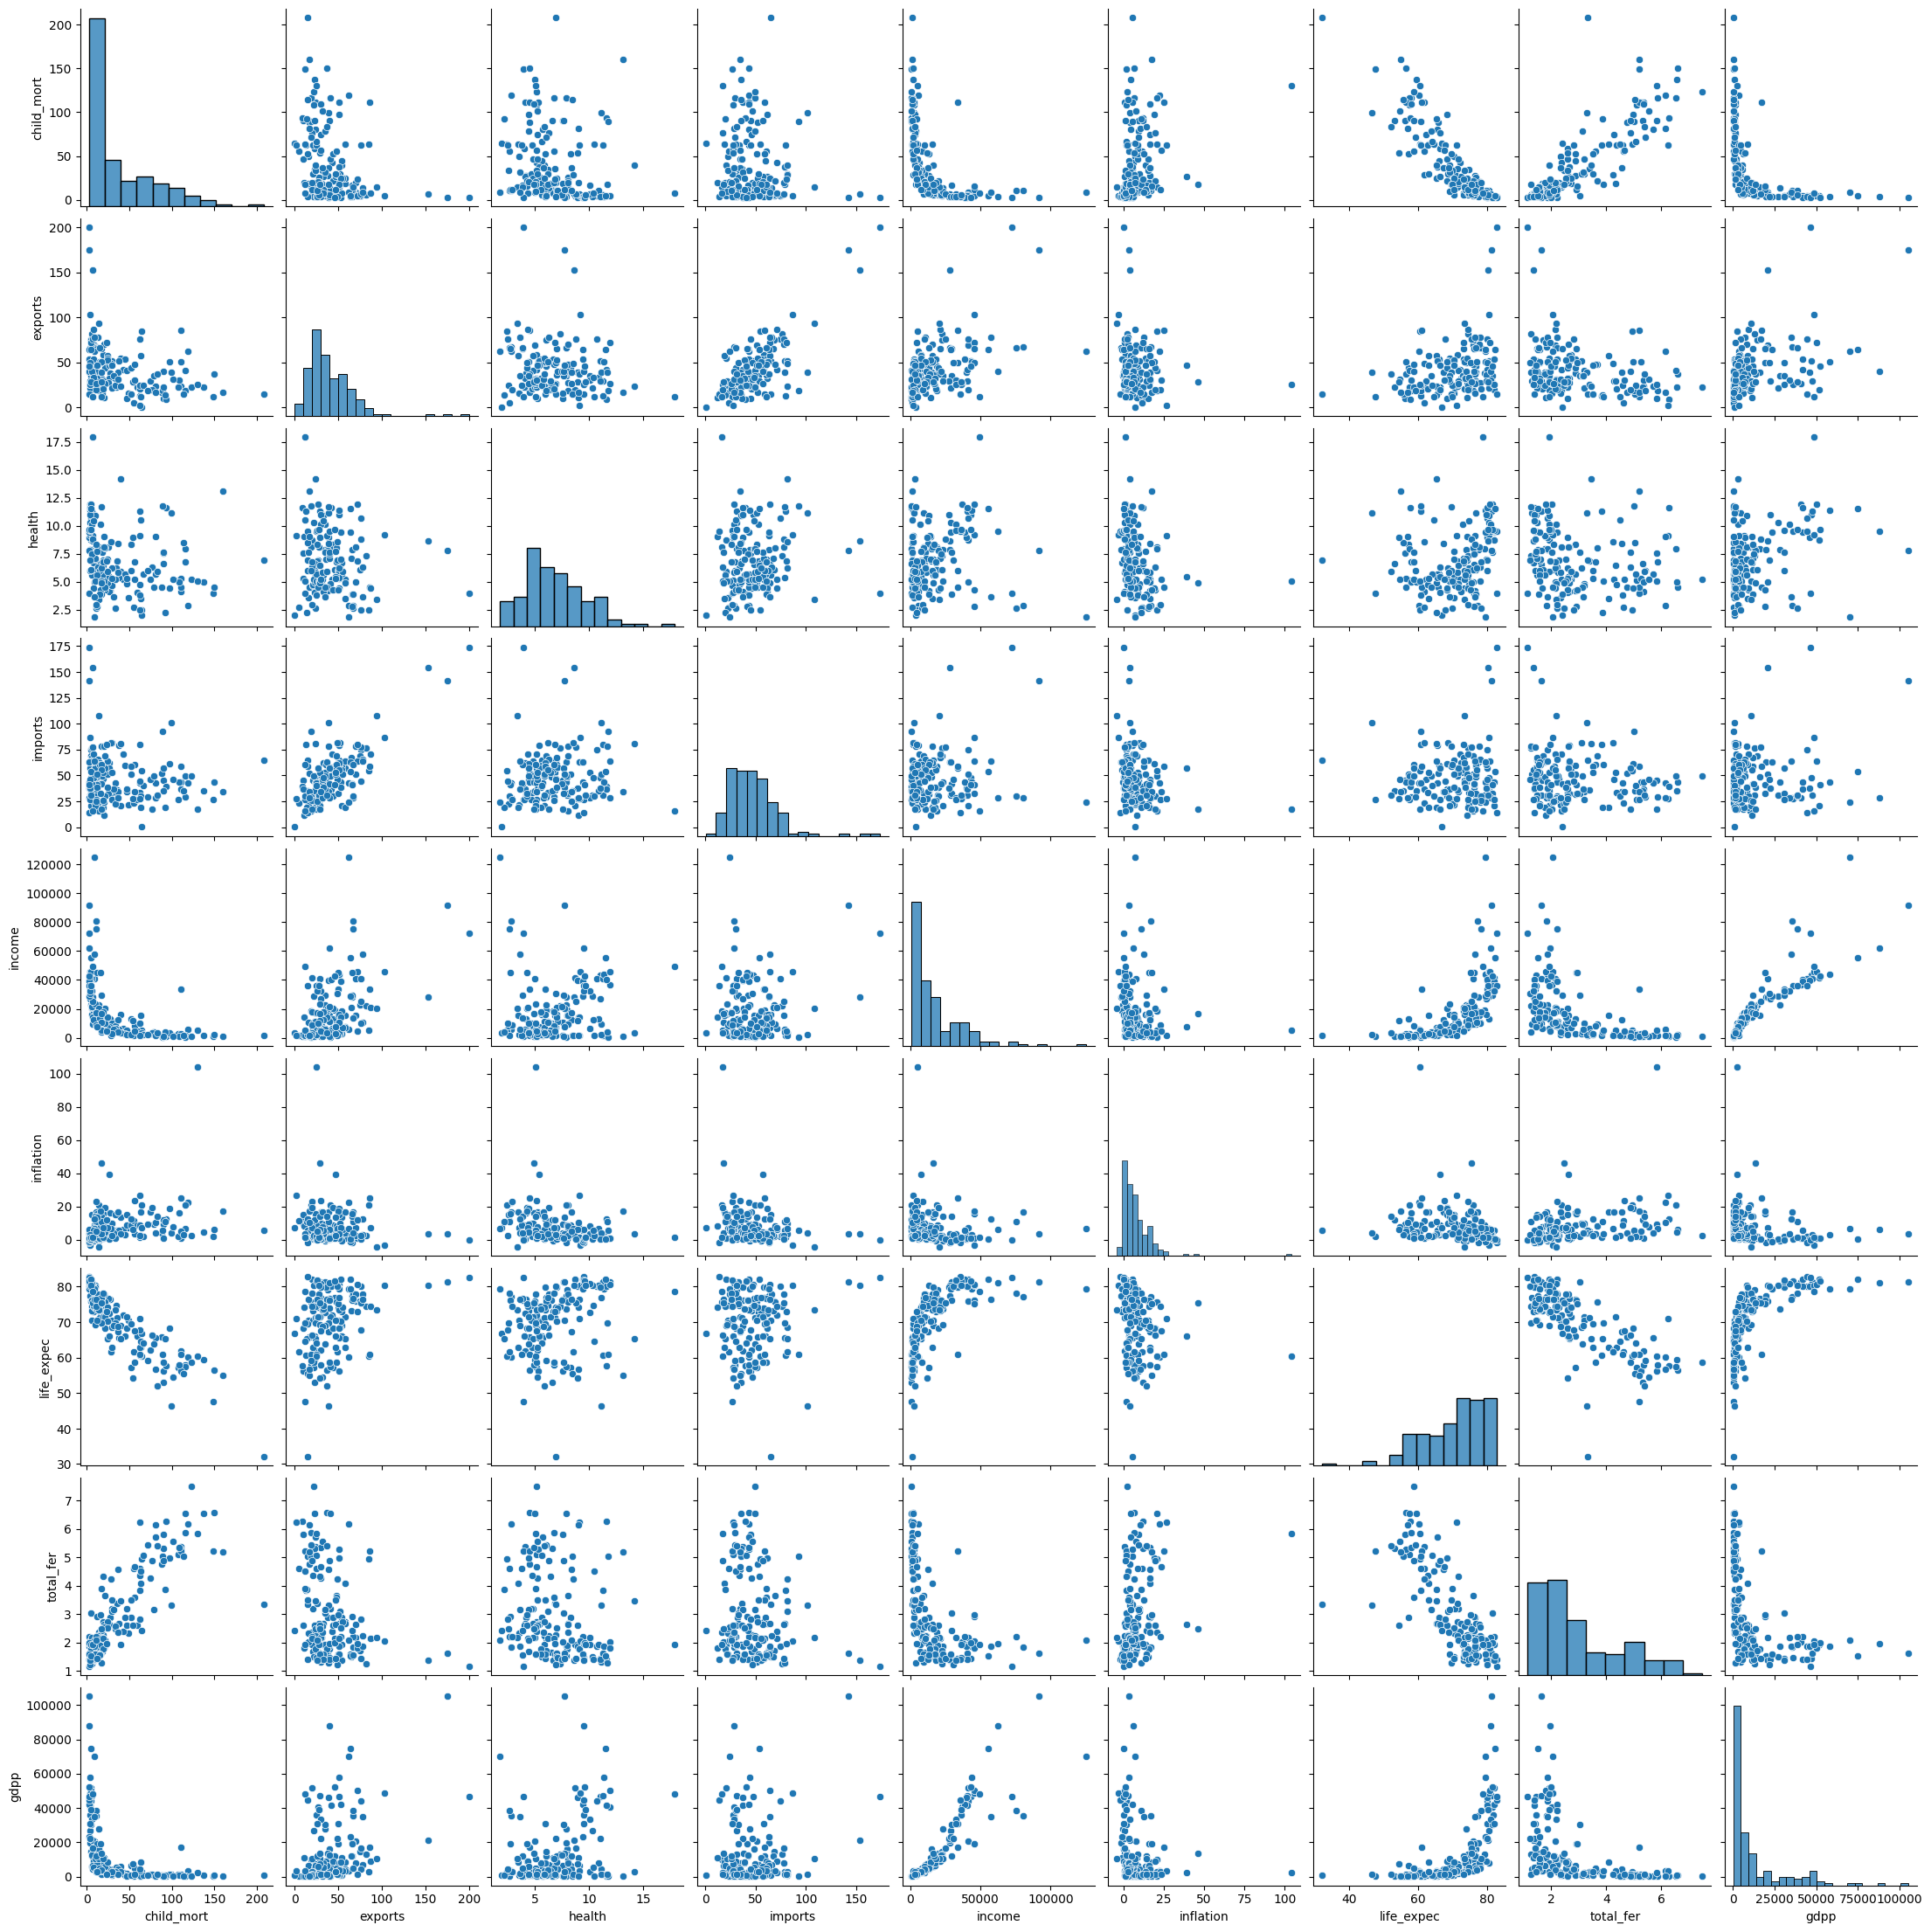

In [49]:
# Pair plot of the dataset
sns.pairplot(df)
plt.show()


Note the peaks in the diagonal graphs that are distinct from each other or only overlap slightly. Looking at the scatter plot distributions may also give you some indication of features that would be good candidates for clustering the data.

### Scaling the Data

In [50]:
# Normalise the data using MinMaxScaler
# Name the normalised dataframe "df_scaled"
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)
df_scaled

#df_scaled.head()

array([[0.42648491, 0.04948197, 0.35860783, ..., 0.47534517, 0.73659306,
        0.00307343],
       [0.06815969, 0.13953104, 0.29459291, ..., 0.87179487, 0.07886435,
        0.03683341],
       [0.12025316, 0.1915594 , 0.14667495, ..., 0.87573964, 0.27444795,
        0.04036499],
       ...,
       [0.10077897, 0.35965101, 0.31261653, ..., 0.8086785 , 0.12618297,
        0.01029885],
       [0.26144109, 0.1495365 , 0.20944686, ..., 0.69822485, 0.55520505,
        0.01029885],
       [0.39191821, 0.18455558, 0.25357365, ..., 0.39250493, 0.670347  ,
        0.01173057]])

## K-Means Clustering

### Selecting K

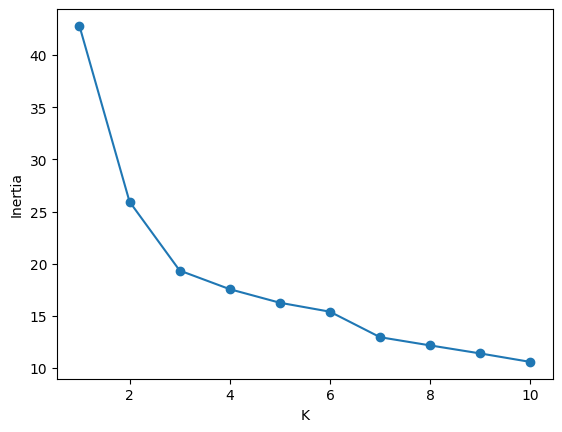

In [51]:
# Plot elbow curve
def eval_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters=k, random_state=r, max_iter=500)
    kmeans.fit(x)
    return kmeans.inertia_

def elbow_Kmeans(x, max_k=10, r=42):
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1, max_k+1)]
    plt.plot(range(1, 11), within_cluster_vars,marker='o')
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.show()

# Plot elbow curve using scaled dataset
elbow_Kmeans(df_scaled)

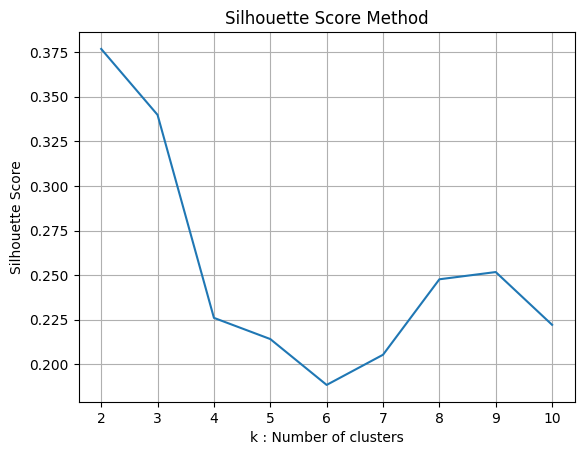

In [52]:
# Silhouette score method
kmax = 10
sil = []
plt.plot()
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters=k, random_state=rseed, max_iter=500)
    kmeans.fit(df_scaled)
    labels = kmeans.labels_
    sil.append(silhouette_score(df_scaled, labels, metric='euclidean'))

sns.lineplot(x=range(2, kmax+1), y=sil)
plt.title('Silhouette Score Method')
plt.xlabel('k : Number of clusters')
plt.ylabel("Silhouette Score")
plt.grid(visible=True)
plt.show()

Based on the elbow and silhouette score method choose a value for K.

The optimal number of clusters is k = 3. The elbow method's plot revealed a significant drop in inertia from k = 1 to k = 3, indicating that the addition of more clusters beyond this point yields diminishing returns in terms of reducing within-cluster variance. Furthermore, while the silhouette score was highest for k = 2, indicating the tightest clustering at this level, k = 3 provided a reasonable balance between the number of clusters and cluster cohesion, as evidenced by the next highest silhouette score. This combination of methods suggests that k = 3 effectively balances cluster compactness and separation, making it the most suitable choice for this dataset.

## Fitting a K-Means Model with the selected K value

In [53]:
# Remember to set the random_state to rseed
rseed = 42

# Fit the model with the optimal number of clusters
optimal_k = 3  # Based on elbow and silhouette score
kmeans = KMeans(n_clusters=optimal_k, random_state=rseed, max_iter=500)
df['cluster'] = kmeans.fit_predict(df_scaled)

In [54]:
# Count the number of records in each cluster
cluster_counts = df['cluster'].value_counts()
print("Number of records in each cluster:")
print(cluster_counts)

Number of records in each cluster:
cluster
0    87
2    45
1    35
Name: count, dtype: int64


In [55]:
# Check model performance with the silhouette coefficient
labels = kmeans.labels_
silhouette_avg = silhouette_score(df_scaled, labels)
print(f'Silhouette Score for the model with {optimal_k} clusters: {silhouette_avg}')

Silhouette Score for the model with 3 clusters: 0.33976487765323604


## Predictions

In [56]:
# Add the predicted cluster label column to the original dataframe
df = pd.DataFrame(df_scaled, columns = columns)

df['cluster'] = labels
df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
0,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073,2
1,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833,0
2,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365,0
3,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488,2
4,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242,0


## Visualisation of clusters

<Axes: xlabel='child_mort', ylabel='gdpp'>

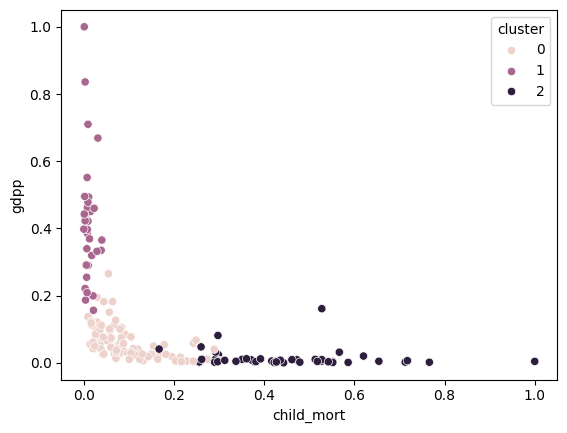

In [57]:
# Visualisation of clusters: child mortality vs gdpp
sns.scatterplot(x = df['child_mort'], y = df['gdpp'], hue = df['cluster'])

<Axes: xlabel='inflation', ylabel='gdpp'>

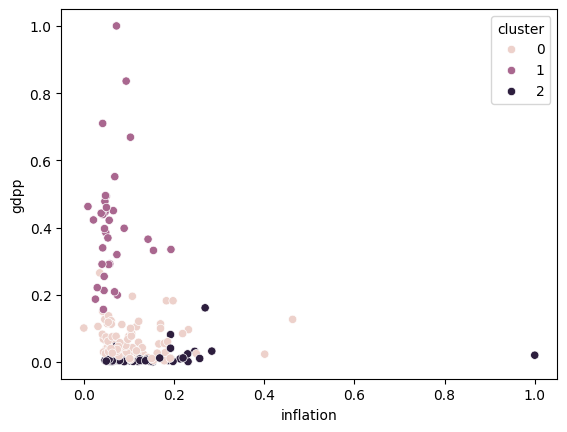

In [58]:
# Visualisation of clusters: inflation vs gdpp
sns.scatterplot(x = df['inflation'], y = df['gdpp'], hue = df['cluster'])

## Conclusions

Label the groups of countries in the plots you created based on child mortality, GDPP and inflation. You may use [terms](https://en.wikipedia.org/wiki/Developing_country#Terms_used_to_classify_countries) such as: least developed, developing and developed, or low, low-middle, upper-middle and high income. Alternatively, simply rank them from highest to lowest. Justify the labels you assign to each group.


**Answer here:**

In [59]:
# Calculate the mean values of each numerical column grouped by cluster
df.groupby('cluster').mean()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
cluster,,,,,,,,,
0,0.096839,0.201990,0.275476,0.271713,0.096755,0.109138,0.796005,0.183854,0.061339
1,0.011184,0.291771,0.441730,0.295760,0.363321,0.062333,0.949620,0.093240,0.409340
2,0.448556,0.143746,0.278392,0.243711,0.023687,0.151784,0.537322,0.624465,0.014068


In [60]:
# Label the groups of countries and rename column
df['cluster'] = df['cluster'].map({0: 'Developing', 1: 'Developed', 2: 'Least Developed'})
df = df.rename(columns ={'cluster':'development_satus'})
df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,development_satus
0,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073,Least Developed
1,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833,Developing
2,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365,Developing
3,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488,Least Developed
4,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242,Developing


The labels "least developed," "developed," and "developing" categorise countries based on the indicators child mortality, GDP per capita, and inflation. These classifications reflect distinct stages of economic development and stability: least developed countries typically have lower GDP per capita, higher child mortality rates, and volatile inflation; developed countries demonstrate higher GDP per capita, lower child mortality rates, and stable inflation; and developing countries fall in between, showing varying degrees of progress across these indicators. These labels facilitate global comparisons, aid in policy formulation tailored to specific developmental needs, and provide a framework for assessing progress towards international development goals.